In [18]:
# ============================================================================
# Cell 1: Imports
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import uniform_filter, gaussian_filter
from skimage.segmentation import slic
from skimage.measure import regionprops

In [19]:
# ============================================================================
# Cell 2: 기본 Smoothing 함수 정의
# ============================================================================

def fill_holes_completely(depth, invalid_value=0.0):
    """구멍을 완전히 채우는 함수 (inpainting + morphological closing)"""
    mask = (depth > invalid_value) & ~np.isnan(depth)
    depth_filled = depth.copy().astype(np.float32)
    
    if mask.all():
        return depth_filled
    
    mask_uint8 = (~mask).astype(np.uint8) * 255
    depth_filled = cv2.inpaint(depth_filled, mask_uint8, 10, cv2.INPAINT_TELEA)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    depth_filled = cv2.morphologyEx(depth_filled, cv2.MORPH_CLOSE, kernel)
    
    return depth_filled


def smooth_heavy_downup(depth, scale=0.1, invalid_value=0.0):
    """매우 강한 다운샘플링으로 디테일 제거 + 구멍 채우기"""
    H, W = depth.shape
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    h_small = max(1, int(H * scale))
    w_small = max(1, int(W * scale))
    depth_small = cv2.resize(depth_filled, (w_small, h_small), interpolation=cv2.INTER_AREA)
    depth_coarse = cv2.resize(depth_small, (W, H), interpolation=cv2.INTER_LINEAR)
    
    return depth_coarse


def smooth_superpixel(depth, n_segments=200, compactness=10, invalid_value=0.0):
    """Superpixel 기반 단순화 - 각 영역을 대표 depth로 표현"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_norm = (depth_filled - depth_filled.min()) / (depth_filled.max() - depth_filled.min() + 1e-8)
    depth_3ch = np.stack([depth_norm] * 3, axis=-1)
    
    segments = slic(depth_3ch, n_segments=n_segments, compactness=compactness, 
                    start_label=0, channel_axis=-1)
    
    depth_simplified = np.zeros_like(depth_filled)
    for region_id in np.unique(segments):
        mask = segments == region_id
        depth_simplified[mask] = depth_filled[mask].mean()
    
    return depth_simplified


def smooth_quantized(depth, n_levels=8, invalid_value=0.0):
    """Depth를 N개의 대표 값으로 양자화"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    valid_mask = depth_filled > invalid_value
    if not valid_mask.any():
        return depth_filled
    
    min_d, max_d = depth_filled[valid_mask].min(), depth_filled[valid_mask].max()
    bins = np.linspace(min_d, max_d, n_levels + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    indices = np.digitize(depth_filled, bins) - 1
    indices = np.clip(indices, 0, n_levels - 1)
    depth_quantized = bin_centers[indices]
    depth_quantized = cv2.GaussianBlur(depth_quantized.astype(np.float32), (5, 5), 1.5)
    
    return depth_quantized


def smooth_iterative_inpaint_blur(depth, iterations=3, blur_sigma=5.0, invalid_value=0.0):
    """반복적 inpainting + 강한 블러로 구멍 채우고 단순화"""
    depth_result = depth.copy().astype(np.float32)
    
    for i in range(iterations):
        mask = (depth_result <= invalid_value) | np.isnan(depth_result)
        if mask.any():
            mask_uint8 = mask.astype(np.uint8) * 255
            depth_result = cv2.inpaint(depth_result, mask_uint8, 5, cv2.INPAINT_TELEA)
        
        kernel_size = int(blur_sigma * 4) | 1
        depth_result = cv2.GaussianBlur(depth_result, (kernel_size, kernel_size), blur_sigma)
    
    return depth_result


def smooth_planar_fit(depth, grid_size=32, invalid_value=0.0):
    """그리드 영역별 평면 fitting으로 단순화"""
    H, W = depth.shape
    depth_filled = fill_holes_completely(depth, invalid_value)
    depth_planar = np.zeros_like(depth_filled)
    
    for i in range(0, H, grid_size):
        for j in range(0, W, grid_size):
            i_end = min(i + grid_size, H)
            j_end = min(j + grid_size, W)
            block = depth_filled[i:i_end, j:j_end]
            depth_planar[i:i_end, j:j_end] = block.mean()
    
    depth_planar = cv2.GaussianBlur(depth_planar.astype(np.float32), (15, 15), 3.0)
    return depth_planar


print('기본 smoothing 함수 정의 완료!')

기본 smoothing 함수 정의 완료!


In [20]:
# ============================================================================
# Cell 3: Superpixel 변형 함수들
# ============================================================================

def smooth_superpixel_extreme(depth, n_segments=30, compactness=30, blur_sigma=3.0, invalid_value=0.0):
    """극단적으로 단순화된 Superpixel - 매우 적은 세그먼트 + 후처리 블러"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_norm = (depth_filled - depth_filled.min()) / (depth_filled.max() - depth_filled.min() + 1e-8)
    depth_3ch = np.stack([depth_norm] * 3, axis=-1)
    
    segments = slic(depth_3ch, n_segments=n_segments, compactness=compactness, 
                    start_label=0, channel_axis=-1)
    
    depth_simplified = np.zeros_like(depth_filled)
    for region_id in np.unique(segments):
        mask = segments == region_id
        depth_simplified[mask] = depth_filled[mask].mean()
    
    if blur_sigma > 0:
        kernel_size = int(blur_sigma * 4) | 1
        depth_simplified = cv2.GaussianBlur(depth_simplified.astype(np.float32), 
                                            (kernel_size, kernel_size), blur_sigma)
    
    return depth_simplified


def smooth_superpixel_hierarchical(depth, levels=[200, 50, 15], invalid_value=0.0):
    """계층적 Superpixel - 여러 단계로 점진적 단순화"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    depth_result = depth_filled.copy()
    
    for n_seg in levels:
        depth_norm = (depth_result - depth_result.min()) / (depth_result.max() - depth_result.min() + 1e-8)
        depth_3ch = np.stack([depth_norm] * 3, axis=-1)
        
        segments = slic(depth_3ch, n_segments=n_seg, compactness=20, 
                        start_label=0, channel_axis=-1)
        
        for region_id in np.unique(segments):
            mask = segments == region_id
            depth_result[mask] = depth_result[mask].mean()
    
    return depth_result


def smooth_superpixel_quantized(depth, n_segments=100, n_depth_levels=5, invalid_value=0.0):
    """Superpixel + Depth 양자화 결합"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_norm = (depth_filled - depth_filled.min()) / (depth_filled.max() - depth_filled.min() + 1e-8)
    depth_3ch = np.stack([depth_norm] * 3, axis=-1)
    segments = slic(depth_3ch, n_segments=n_segments, compactness=15, 
                    start_label=0, channel_axis=-1)
    
    depth_sp = np.zeros_like(depth_filled)
    for region_id in np.unique(segments):
        mask = segments == region_id
        depth_sp[mask] = depth_filled[mask].mean()
    
    min_d, max_d = depth_sp.min(), depth_sp.max()
    bins = np.linspace(min_d, max_d, n_depth_levels + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    indices = np.digitize(depth_sp, bins) - 1
    indices = np.clip(indices, 0, n_depth_levels - 1)
    depth_quantized = bin_centers[indices]
    
    return depth_quantized


print('Superpixel 변형 함수 정의 완료!')

Superpixel 변형 함수 정의 완료!


In [21]:
# ============================================================================
# Cell 4: Binning 함수들 (Classification용)
# ============================================================================

def depth_to_bins(depth, n_bins=128, depth_min=None, depth_max=None, invalid_value=0.0):
    """Depth를 N개의 bin (class label)로 변환 - Linear"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    if depth_min is None:
        depth_min = depth_filled[depth_filled > invalid_value].min()
    if depth_max is None:
        depth_max = depth_filled.max()
    
    bins = np.linspace(depth_min, depth_max, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    bin_indices = np.digitize(depth_filled, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    return bin_indices, bin_centers, bins


def depth_to_bins_log(depth, n_bins=128, invalid_value=0.0):
    """Log-scale binning - 가까운 거리에 더 많은 bin 할당"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_min = depth_filled[depth_filled > invalid_value].min()
    depth_max = depth_filled.max()
    
    bins = np.logspace(np.log10(depth_min), np.log10(depth_max), n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    bin_indices = np.digitize(depth_filled, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    return bin_indices, bin_centers, bins


def depth_to_bins_sid(depth, n_bins=128, alpha=0.5, invalid_value=0.0):
    """SID (Spacing-Increasing Discretization) - DORN paper 방식"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_min = depth_filled[depth_filled > invalid_value].min()
    depth_max = depth_filled.max()
    
    t = np.linspace(0, 1, n_bins + 1)
    bins = depth_min * (depth_max / depth_min) ** (t ** alpha)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    bin_indices = np.digitize(depth_filled, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    return bin_indices, bin_centers, bins


def bins_to_depth(bin_indices, bin_centers):
    """Bin indices를 다시 depth 값으로 변환"""
    return bin_centers[bin_indices]


def smooth_binned(depth, n_bins=128, pre_smooth=None, post_blur=0, invalid_value=0.0):
    """Bin 기반 단순화 + 선택적 전/후처리"""
    depth_processed = depth.copy().astype(np.float32)
    
    if pre_smooth == 'downup':
        depth_processed = smooth_heavy_downup(depth_processed, scale=0.1)
    elif pre_smooth == 'superpixel':
        depth_processed = smooth_superpixel(depth_processed, n_segments=100)
    
    bin_indices, bin_centers, _ = depth_to_bins(depth_processed, n_bins=n_bins)
    depth_binned = bins_to_depth(bin_indices, bin_centers)
    
    if post_blur > 0:
        kernel_size = int(post_blur * 4) | 1
        depth_binned = cv2.GaussianBlur(depth_binned.astype(np.float32), 
                                        (kernel_size, kernel_size), post_blur)
    
    return depth_binned, bin_indices


print('Binning 함수 정의 완료!')

Binning 함수 정의 완료!


In [22]:
# ============================================================================
# Cell 5: 데이터 로드
# ============================================================================

base_path = '/root/dev/data/dataset/Batvision/BatvisionV2/2ndFloorLuxembourg'
file_idx = 0

# 원본 depth 로드
depth_original = np.load(f'{base_path}/depth/depth_{file_idx}.npy').astype(np.float32)

# 컬러 범위 설정
valid_mask = depth_original > 0
vmin, vmax = depth_original[valid_mask].min(), depth_original[valid_mask].max()

print(f'Depth loaded: {depth_original.shape}')
print(f'Valid range: {vmin:.1f} ~ {vmax:.1f}')

Depth loaded: (720, 1280)
Valid range: 629.0 ~ 11929.0


30개 방법 계산 중...
30개 방법 준비 완료!


/tmp/ipykernel_885200/97508363.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.99])


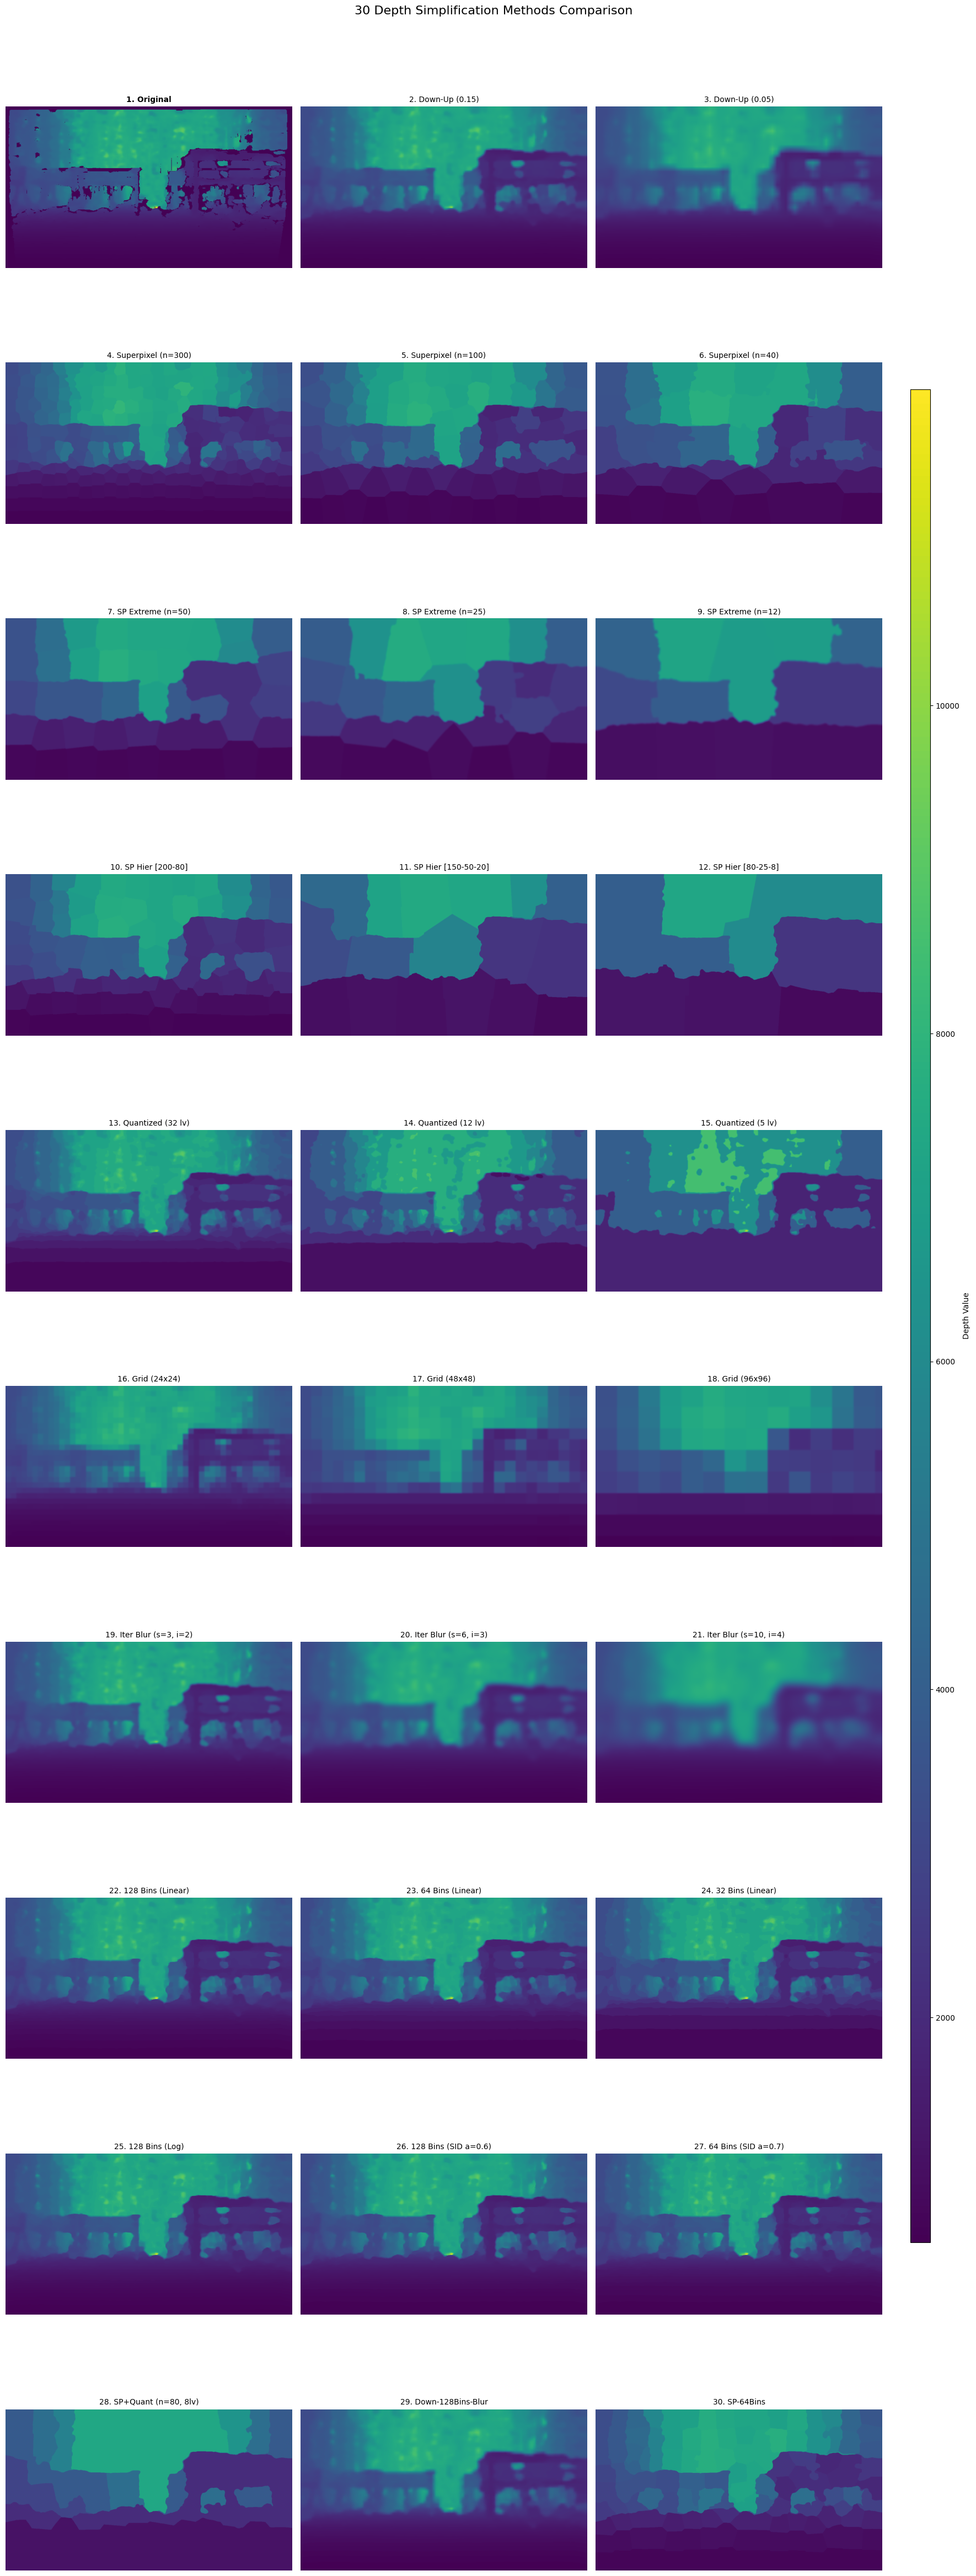


all_30_methods.png 저장 완료!


In [23]:
# ============================================================================
# Cell 6: 전체 30개 방법 종합 시각화 (10 x 3 Grid)
# ============================================================================

print('30개 방법 계산 중...')

all_30_methods = [
    # Row 1: Original + Down-Up
    ('1. Original', depth_original),
    ('2. Down-Up (0.15)', smooth_heavy_downup(depth_original, scale=0.15)),
    ('3. Down-Up (0.05)', smooth_heavy_downup(depth_original, scale=0.05)),
    
    # Row 2: Superpixel 기본
    ('4. Superpixel (n=300)', smooth_superpixel(depth_original, n_segments=300)),
    ('5. Superpixel (n=100)', smooth_superpixel(depth_original, n_segments=100)),
    ('6. Superpixel (n=40)', smooth_superpixel(depth_original, n_segments=40)),
    
    # Row 3: Superpixel Extreme
    ('7. SP Extreme (n=50)', smooth_superpixel_extreme(depth_original, n_segments=50, blur_sigma=2.0)),
    ('8. SP Extreme (n=25)', smooth_superpixel_extreme(depth_original, n_segments=25, blur_sigma=3.0)),
    ('9. SP Extreme (n=12)', smooth_superpixel_extreme(depth_original, n_segments=12, blur_sigma=4.0)),
    
    # Row 4: Superpixel Hierarchical
    ('10. SP Hier [200-80]', smooth_superpixel_hierarchical(depth_original, levels=[200, 80])),
    ('11. SP Hier [150-50-20]', smooth_superpixel_hierarchical(depth_original, levels=[150, 50, 20])),
    ('12. SP Hier [80-25-8]', smooth_superpixel_hierarchical(depth_original, levels=[80, 25, 8])),
    
    # Row 5: Quantization
    ('13. Quantized (32 lv)', smooth_quantized(depth_original, n_levels=32)),
    ('14. Quantized (12 lv)', smooth_quantized(depth_original, n_levels=12)),
    ('15. Quantized (5 lv)', smooth_quantized(depth_original, n_levels=5)),
    
    # Row 6: Planar Grid
    ('16. Grid (24x24)', smooth_planar_fit(depth_original, grid_size=24)),
    ('17. Grid (48x48)', smooth_planar_fit(depth_original, grid_size=48)),
    ('18. Grid (96x96)', smooth_planar_fit(depth_original, grid_size=96)),
    
    # Row 7: Iterative Blur
    ('19. Iter Blur (s=3, i=2)', smooth_iterative_inpaint_blur(depth_original, iterations=2, blur_sigma=3.0)),
    ('20. Iter Blur (s=6, i=3)', smooth_iterative_inpaint_blur(depth_original, iterations=3, blur_sigma=6.0)),
    ('21. Iter Blur (s=10, i=4)', smooth_iterative_inpaint_blur(depth_original, iterations=4, blur_sigma=10.0)),
    
    # Row 8: Binning (Linear)
    ('22. 128 Bins (Linear)', bins_to_depth(*depth_to_bins(depth_original, n_bins=128)[:2])),
    ('23. 64 Bins (Linear)', bins_to_depth(*depth_to_bins(depth_original, n_bins=64)[:2])),
    ('24. 32 Bins (Linear)', bins_to_depth(*depth_to_bins(depth_original, n_bins=32)[:2])),
    
    # Row 9: Binning (Log/SID)
    ('25. 128 Bins (Log)', bins_to_depth(*depth_to_bins_log(depth_original, n_bins=128)[:2])),
    ('26. 128 Bins (SID a=0.6)', bins_to_depth(*depth_to_bins_sid(depth_original, n_bins=128, alpha=0.6)[:2])),
    ('27. 64 Bins (SID a=0.7)', bins_to_depth(*depth_to_bins_sid(depth_original, n_bins=64, alpha=0.7)[:2])),
    
    # Row 10: Combined
    ('28. SP+Quant (n=80, 8lv)', smooth_superpixel_quantized(depth_original, n_segments=80, n_depth_levels=8)),
    ('29. Down-128Bins-Blur', smooth_binned(depth_original, n_bins=128, pre_smooth='downup', post_blur=2.0)[0]),
    ('30. SP-64Bins', smooth_binned(smooth_superpixel(depth_original, n_segments=150), n_bins=64)[0]),
]

print(f'{len(all_30_methods)}개 방법 준비 완료!')

# 10 x 3 그리드 시각화
fig, axes = plt.subplots(10, 3, figsize=(18, 48))
axes = axes.flatten()

for idx, (ax, (name, data)) in enumerate(zip(axes, all_30_methods)):
    im = ax.imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title(name, fontsize=10, fontweight='bold' if idx == 0 else 'normal')
    ax.axis('off')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Depth Value')

plt.suptitle('30 Depth Simplification Methods Comparison', fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0, 0.9, 0.99])
plt.savefig('all_30_methods.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nall_30_methods.png 저장 완료!')

In [24]:
# ============================================================================
# Cell 7: 30개 방법 요약표
# ============================================================================

summary = '''
============================================================================
                   30개 Depth 단순화 방법 요약
============================================================================

Row 1: Down-Up (다운샘플링)
  - Original -> scale=0.15 -> scale=0.05
  - 공간적 해상도 감소, 저주파 보존

Row 2: Superpixel (영역 기반)
  - n=300 -> n=100 -> n=40
  - 유사 depth 영역으로 분할, 각 영역 평균 depth

Row 3: SP Extreme (강한 영역화 + Blur)
  - n=50 -> n=25 -> n=12
  - 적은 영역 + 후처리 블러로 경계 부드럽게

Row 4: SP Hierarchical (계층적)
  - [200-80] -> [150-50-20] -> [80-25-8]
  - 다단계 점진적 단순화

Row 5: Quantization (depth 이산화)
  - 32 levels -> 12 levels -> 5 levels
  - depth 값을 N개 대표값으로 양자화

Row 6: Planar Grid (블록 기반)
  - 24x24 -> 48x48 -> 96x96
  - 고정 그리드로 분할, 블록당 평균값

Row 7: Iterative Blur (반복 블러)
  - (s=3,i=2) -> (s=6,i=3) -> (s=10,i=4)
  - 구멍 채우기 + 강한 가우시안 블러

Row 8: Binning Linear (균등 분할)
  - 128 bins -> 64 bins -> 32 bins
  - 균등한 bin 폭, Classification용

Row 9: Binning Log/SID (비균등 분할)
  - 128 Log -> 128 SID -> 64 SID
  - 가까운 거리에 더 촘촘한 bin

Row 10: Combined (조합)
  - SP+Quant -> Down-Bins-Blur -> SP-Bins
  - 여러 방법 결합

============================================================================
용도별 추천:
  - Coarse Classification (128 bins): #22, #25, #26, #29
  - 영역 기반 대표 depth: #5, #8, #11, #28
  - 연속적/부드러운 결과: #3, #20, #21
  - 강한 단순화 (뭉개기): #9, #12, #15, #18
============================================================================
'''

print(summary)

# 각 방법별 고유 depth 값 수 계산
print('\n각 방법별 고유 depth 값 수:')
print('-' * 50)
for i, (name, data) in enumerate(all_30_methods):
    unique_count = len(np.unique(data.round(1)))
    print(f'  {name:30s}: {unique_count:6d} unique values')


                   30개 Depth 단순화 방법 요약

Row 1: Down-Up (다운샘플링)
  - Original -> scale=0.15 -> scale=0.05
  - 공간적 해상도 감소, 저주파 보존

Row 2: Superpixel (영역 기반)
  - n=300 -> n=100 -> n=40
  - 유사 depth 영역으로 분할, 각 영역 평균 depth

Row 3: SP Extreme (강한 영역화 + Blur)
  - n=50 -> n=25 -> n=12
  - 적은 영역 + 후처리 블러로 경계 부드럽게

Row 4: SP Hierarchical (계층적)
  - [200-80] -> [150-50-20] -> [80-25-8]
  - 다단계 점진적 단순화

Row 5: Quantization (depth 이산화)
  - 32 levels -> 12 levels -> 5 levels
  - depth 값을 N개 대표값으로 양자화

Row 6: Planar Grid (블록 기반)
  - 24x24 -> 48x48 -> 96x96
  - 고정 그리드로 분할, 블록당 평균값

Row 7: Iterative Blur (반복 블러)
  - (s=3,i=2) -> (s=6,i=3) -> (s=10,i=4)
  - 구멍 채우기 + 강한 가우시안 블러

Row 8: Binning Linear (균등 분할)
  - 128 bins -> 64 bins -> 32 bins
  - 균등한 bin 폭, Classification용

Row 9: Binning Log/SID (비균등 분할)
  - 128 Log -> 128 SID -> 64 SID
  - 가까운 거리에 더 촘촘한 bin

Row 10: Combined (조합)
  - SP+Quant -> Down-Bins-Blur -> SP-Bins
  - 여러 방법 결합

용도별 추천:
  - Coarse Classification (128 bins): #22, #25, #26, #29
  - 